# _Imports_, constantes e funções

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

from keras import datasets, layers, optimizers, models
from IPython.display import Markdown, display
from keras.models import model_from_json

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

B_CATEGORIES = [7,3] #Número de matricula: 2016058573
EPPOCHS = 20
A_MODEL_NAME = 'a_model.json'
A_MODEL_WEIGTHS = 'a_weights.h5'
OPTMIZER = optimizers.Adam(lr=0.0005)

Using TensorFlow backend.


In [0]:
def GetModel(imgShape, countClass):  
    model = models.Sequential()
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu", 
                   padding="same", name="Conv1", input_shape=imgShape))
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu", 
                   padding="same", name="Conv2"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), name="Pool1"))
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu", 
                   padding="same", name="Conv3"))
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu", 
                   padding="same", name="Conv4"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), name="Pool2"))
    model.add(layers.Flatten(name="Flatten"))
    model.add(layers.Dense(128, activation="relu", name="Dense1"))
    model.add(layers.Dropout(0.4, name="Dropout"))
    model.add(layers.Dense(countClass, activation="softmax", name="Output"))
    model.compile(OPTMIZER, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

def GetModelFromSavedAndAlterLayers(newLayers):
    json_file = open(A_MODEL_NAME, 'r')
    loaded_model_json = json_file.read()
    json_file.close()

    model = model_from_json(loaded_model_json)
    model.load_weights(A_MODEL_WEIGTHS)

    for i in range(0, len(newLayers)):
        model.pop()
    for layer in model.layers:
        layer.trainable = False
    for layer in newLayers:
        model.add(layer)  
        
    model.compile(OPTMIZER, loss="categorical_crossentropy", metrics=["accuracy"])
    return model  

def GetDataset():
    (trainData, trainLabels), (testData, testLabels) = datasets.mnist.load_data()
    img_shape = trainData.shape[1:] + (1, )

    trainData = trainData/255
    testData = testData/255

    dataset = {'imgShape': img_shape, 'A': None, 'B': None}
    dataset['A'] = { 'trainData': [], 'trainLabels': [], 
                   'testData': [], 'testLabels': [], 'countClass': 0 }
    dataset['B'] = { 'trainData': [], 'trainLabels': [], 
                   'testData': [], 'testLabels': [], 'countClass': 0 }

    for i in range(0, len(trainData)):
        if(trainLabels[i] in B_CATEGORIES):
            dataset['B']['trainData'].append(trainData[i])
            dataset['B']['trainLabels'].append(trainLabels[i])
        else:
            dataset['A']['trainData'].append(trainData[i])
            dataset['A']['trainLabels'].append(trainLabels[i])

    for i in range(0, len(testData)):
        if(testLabels[i] in B_CATEGORIES):
            dataset['B']['testData'].append(testData[i])
            dataset['B']['testLabels'].append(testLabels[i])
        else:
            dataset['A']['testData'].append(testData[i])
            dataset['A']['testLabels'].append(testLabels[i])

    for subset in ['A', 'B']:
        dataset[subset]['trainData'] = np.expand_dims(dataset[subset]['trainData'], 3)
        dataset[subset]['testData'] = np.expand_dims(dataset[subset]['testData'], 3)
        dataset[subset]['countClass'] = len(set((dataset[subset]['trainLabels'] + dataset[subset]['testLabels'])))
        dataset[subset]['trainLabels'] = pd.get_dummies(dataset[subset]['trainLabels']).values
        dataset[subset]['testLabels'] = pd.get_dummies(dataset[subset]['testLabels']).values

    return dataset

def ShowGraph(history):
    mpl.rc("font", **{"size": 14})
    fig, axes = plt.subplots(1, 2, figsize=(17, 7))

    axes[0].plot(range(1, len(history.history["loss"])+1), history.history["loss"], 
          label="Train Loss", color="royalblue", lw=3)
    axes[0].set_ylabel("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_xticks(range(1, len(history.history["acc"])+1))
    axes[0].legend()

    axes[1].plot(range(1, len(history.history["acc"])+1), history.history["acc"], 
          label="Train ACC", color="royalblue", lw=3)
    axes[1].plot(range(1, len(history.history["val_acc"])+1), history.history["val_acc"], 
          label="Teste ACC", color="forestgreen", lw=3)
    axes[1].set_ylabel("Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_xticks(range(1, len(history.history["acc"])+1))
    axes[1].legend()
    plt.show()

# Primeira parte - Classificação utilizando dados de categorias do grupo A

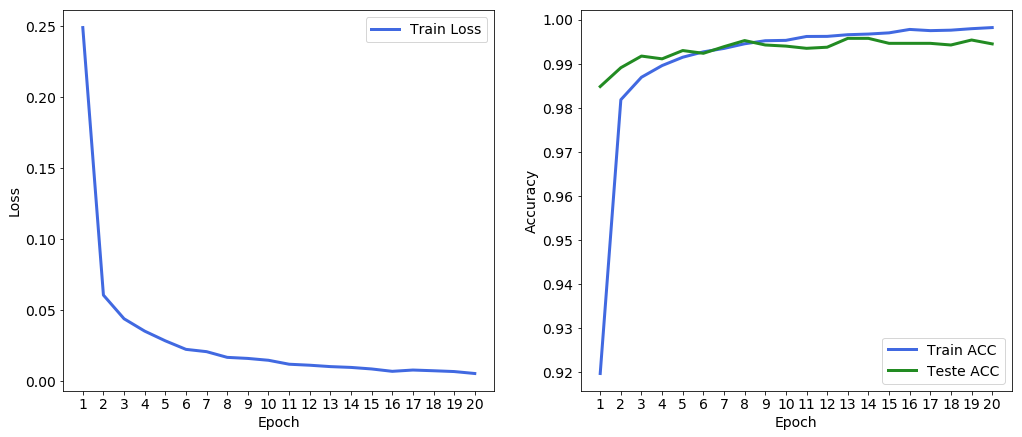

In [3]:
dataset = GetDataset()
model = GetModel(dataset['imgShape'], dataset['A']['countClass'])

history = model.fit(dataset['A']['trainData'], dataset['A']['trainLabels'], batch_size=128, epochs=EPPOCHS, 
                    validation_data=(dataset['A']['testData'], dataset['A']['testLabels']), verbose=0)
model.save_weights("a_weights.h5")

model_json = model.to_json()
with open(A_MODEL_NAME, "w") as json_file:
    json_file.write(model_json)
model.save_weights(A_MODEL_WEIGTHS)

ShowGraph(history)

# Segunda parte - Classificação utilizando dados de categorias do grupo B
## Primeira tentaiva - Treinando do zero

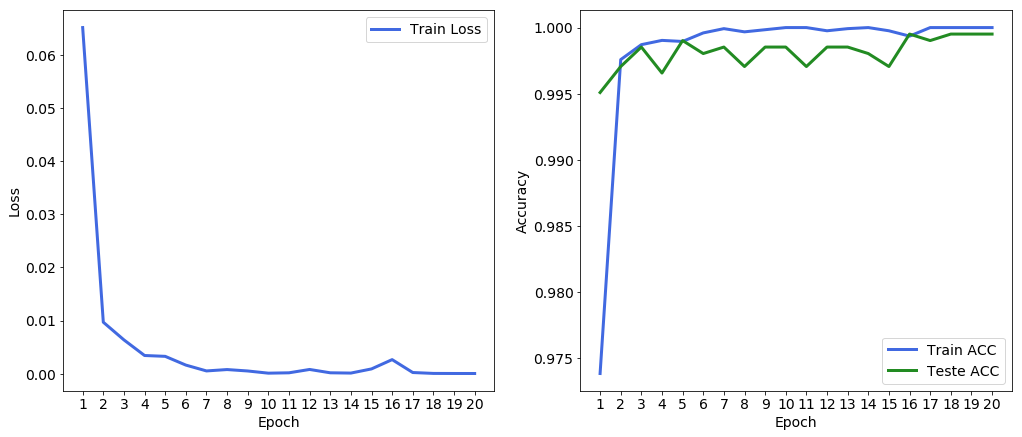

In [4]:
model = GetModel(dataset['imgShape'], dataset['B']['countClass'])

history = model.fit(dataset['B']['trainData'], dataset['B']['trainLabels'], batch_size=128, epochs=EPPOCHS, 
                    validation_data=(dataset['B']['testData'], dataset['B']['testLabels']), verbose=0)
ShowGraph(history)

## Segunda tentaiva - _Fine Tunning_ na última camada

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
Conv2 (Conv2D)               (None, 28, 28, 64)        18496     
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 14, 14, 64)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 14, 14, 64)        36928     
_________________________________________________________________
Conv4 (Conv2D)               (None, 14, 14, 64)        36928     
_________________________________________________________________
Pool2 (MaxPooling2D)         (None, 7, 7, 64)          0         
_________________________________________________________________
Flatten (Flatten)            (None, 3136)              0         
__________

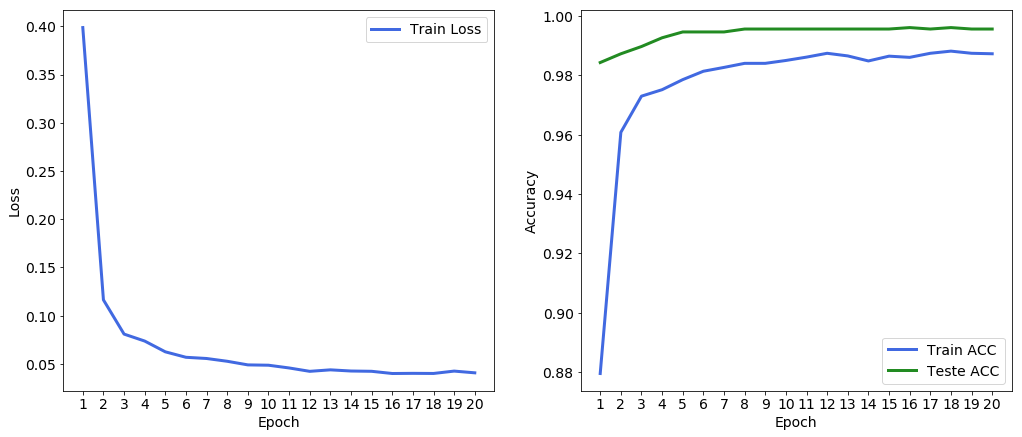

In [5]:
model = GetModelFromSavedAndAlterLayers([layers.Dense(dataset['B']['countClass'], activation='softmax', name="Output")])
model.summary()

history = model.fit(dataset['B']['trainData'], dataset['B']['trainLabels'], batch_size=128, epochs=EPPOCHS, 
                    validation_data=(dataset['B']['testData'], dataset['B']['testLabels']), verbose=0)
ShowGraph(history)


## Terceira tentaiva - _Fine Tunning_ nas duas últimas camadas

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
Conv2 (Conv2D)               (None, 28, 28, 64)        18496     
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 14, 14, 64)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 14, 14, 64)        36928     
_________________________________________________________________
Conv4 (Conv2D)               (None, 14, 14, 64)        36928     
_________________________________________________________________
Pool2 (MaxPooling2D)         (None, 7, 7, 64)          0         
_________________________________________________________________
Flatten (Flatten)            (None, 3136)              0         
__________

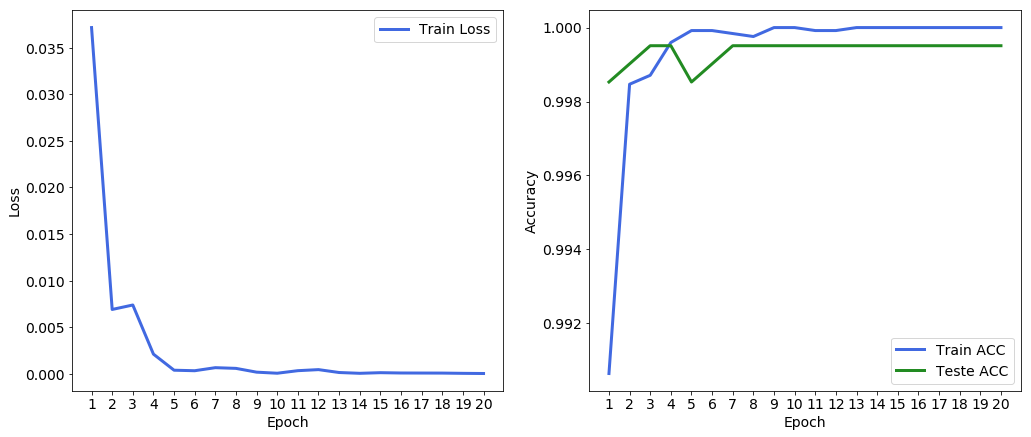

In [7]:
model = GetModelFromSavedAndAlterLayers([layers.Dense(128, activation="relu", name="Dense1"), 
                                         layers.Dropout(0.4, name="Dropout"), 
                                         layers.Dense(dataset['B']['countClass'], activation='softmax', name="Output")])
model.summary()

history = model.fit(dataset['B']['trainData'], dataset['B']['trainLabels'], batch_size=128, epochs=EPPOCHS, 
                    validation_data=(dataset['B']['testData'], dataset['B']['testLabels']), verbose=0)
ShowGraph(history)


#Conclusão
Pelos gráficos obtidos nos 4 experimentos, podemos ver que o uso de _Transfer Learning_ é útil pois diminui tempo gasto, diminui o erro e ainda aumenta a a acurácia no teste. Analisando os dois últimos testes, percebemos que ao utilizar Fine Tunning_ em mais camadas conseguimos (além dos benefícios já citados de _Transfer Learning_) também um ganho na acurácia no treino, o que faz sentido já que a rede terá mais paramêtros à serem efetivamente treinados.